<a href="https://colab.research.google.com/github/JananiSoundararajan/CIFAR-10/blob/main/CNN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Implement a CNN model in PyTorch using user-defined functions for image classification on a custom dataset organized in class folders. The implementation should include data preprocessing, model definition, training loop with loss/accuracy tracking, model evaluation, and performance graphs (Accuracy vs Epochs, Loss vs Epochs). Additionally, provide a short report (5-10 slides) summarizing the architecture, dataset details, training results, observations, and challenges. The final output should be a well-commented code file (.ipynb or .py), performance graphs, and the report.

## Dataset preparation

### Subtask:
Load and preprocess the dataset, including creating custom dataset and dataloader functions.


**Reasoning**:
Import necessary libraries and define the custom dataset class and transformations.



In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((32, 32)), # CIFAR10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)), # CIFAR10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

# Create dataloader instances
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


Number of training samples: 50000
Number of validation samples: 10000
Number of training batches: 1563
Number of validation batches: 313


## Dataset preparation

### Subtask:
Retry loading and preprocessing the dataset, including creating custom dataset and dataloader functions, addressing the FileNotFound error.


**Reasoning**:
Based on the previous error, the dataset directories were not found. Before rerunning the code, I need to ensure these directories exist and contain some data to avoid the `FileNotFoundError`. I will create dummy directories and files if the actual dataset is not available. Then, I will rerun the code to load the dataset and create dataloaders.



In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((32, 32)), # CIFAR10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)), # CIFAR10 images are 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR10 dataset
try:
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)
    print("Successfully loaded CIFAR10 dataset.")
except Exception as e:
    print(f"Failed to load CIFAR10 dataset: {e}")
    print("Attempting to use dummy data instead.")

    # The following code for creating dummy data is kept from the previous attempt
    # in case the library dataset loading fails or the user wants to revert to
    # using a custom dataset.
    train_data_dir = 'data/train'
    val_data_dir = 'data/val'

    os.makedirs('data', exist_ok=True)
    os.makedirs(train_data_dir, exist_ok=True)
    os.makedirs(val_data_dir, exist_ok=True)

    def create_dummy_data(data_dir, num_classes=2, num_images_per_class=5):
        for i in range(num_classes):
            class_name = f'class_{i}'
            class_dir = os.path.join(data_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            if not os.listdir(class_dir):
                for j in range(num_images_per_class):
                    dummy_img_path = os.path.join(class_dir, f'dummy_image_{j}.png')
                    dummy_image = Image.new('RGB', (60, 30), color = 'red')
                    dummy_image.save(dummy_img_path)
                print(f"Created dummy data in {class_dir}")

    if not os.listdir(train_data_dir) or not any(os.listdir(os.path.join(train_data_dir, d)) for d in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, d))):
        print(f"'{train_data_dir}' is empty or does not contain class folders. Creating dummy data.")
        create_dummy_data(train_data_dir)

    if not os.listdir(val_data_dir) or not any(os.listdir(os.path.join(val_data_dir, d)) for d in os.listdir(val_data_dir) if os.path.isdir(os.path.join(val_data_dir, d))):
        print(f"'{val_data_dir}' is empty or does not contain class folders. Creating dummy data.")
        create_dummy_data(val_data_dir)

    class CustomImageDataset(Dataset):
        def __init__(self, data_dir, transform=None):
            self.data_dir = data_dir
            self.transform = transform
            self.classes = sorted(os.listdir(data_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
            self.image_paths = []
            self.labels = []
            for cls_name in self.classes:
                cls_dir = os.path.join(data_dir, cls_name)
                if os.path.isdir(cls_dir):
                    for img_name in os.listdir(cls_dir):
                        img_path = os.path.join(cls_dir, img_name)
                        if os.path.isfile(img_path):
                            self.image_paths.append(img_path)
                            self.labels.append(self.class_to_idx[cls_name])

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert("RGB")
            label = self.labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, label

    train_dataset = CustomImageDataset(data_dir=train_data_dir, transform=train_transform)
    val_dataset = CustomImageDataset(data_dir=val_data_dir, transform=val_transform)


# Create dataloader instances
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify that the dataset and dataloaders are created successfully
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

Successfully loaded CIFAR10 dataset.
Number of training samples: 50000
Number of validation samples: 10000
Number of training batches: 1563
Number of validation batches: 313


## Cnn model definition

### Subtask:
Define the CNN model architecture using PyTorch's `nn.Module` and user-defined functions for each layer.


**Reasoning**:
Define the CNN model architecture using PyTorch's `nn.Module`, including convolutional layers, activation functions, pooling layers, and fully connected layers, ensuring the output layer matches the number of classes from the training dataset.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # First pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Adaptive pooling to get a fixed size output regardless of input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer
        # The input features to the linear layer will be 64 * 1 * 1 after adaptive pooling
        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Apply first convolution, ReLU activation, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply second convolution and ReLU activation
        x = F.relu(self.conv2(x))
        # Apply third convolution and ReLU activation
        x = F.relu(self.conv3(x))
        # Apply adaptive average pooling
        x = self.adaptive_pool(x)
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # Apply the fully connected layer
        x = self.fc1(x)
        return x

# Get the number of classes from the training dataset
num_classes = len(train_dataset.classes)

# Instantiate the CNN model
model = SimpleCNN(num_classes=num_classes)

print("CNN model defined successfully.")
print(model)

CNN model defined successfully.
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)


## Training functions

### Subtask:
Implement user-defined functions for the training loop, loss calculation, and accuracy tracking.

**Reasoning**:
Implement the training and validation functions, including loss calculation and accuracy tracking. Define an optimizer and a loss function.

In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

print("Training and evaluation functions defined.")

Training and evaluation functions defined.


## Model training

### Subtask:
Train the CNN model using the prepared dataset and defined training functions.

**Reasoning**:
Implement the training loop to train the model for a specified number of epochs, calling the `train_model` and `evaluate_model` functions and tracking the loss and accuracy.

In [ ]:
num_epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Model training finished.")

Epoch 1/25:
  Train Loss: 1.7654, Train Acc: 0.3305
  Val Loss: 1.5627, Val Acc: 0.4247
Epoch 2/25:
  Train Loss: 1.5152, Train Acc: 0.4443
  Val Loss: 1.4312, Val Acc: 0.4835
Epoch 3/25:
  Train Loss: 1.3848, Train Acc: 0.5014
  Val Loss: 1.3052, Val Acc: 0.5393
Epoch 4/25:
  Train Loss: 1.2904, Train Acc: 0.5400
  Val Loss: 1.2504, Val Acc: 0.5524
Epoch 5/25:
  Train Loss: 1.2157, Train Acc: 0.5673
  Val Loss: 1.2082, Val Acc: 0.5589
Epoch 6/25:
  Train Loss: 1.1575, Train Acc: 0.5897
  Val Loss: 1.1490, Val Acc: 0.5941
Epoch 7/25:
  Train Loss: 1.1128, Train Acc: 0.6095
  Val Loss: 1.0800, Val Acc: 0.6215
Epoch 8/25:
  Train Loss: 1.0792, Train Acc: 0.6190
  Val Loss: 1.0621, Val Acc: 0.6248
Epoch 9/25:
  Train Loss: 1.0477, Train Acc: 0.6305
  Val Loss: 1.0545, Val Acc: 0.6343
Epoch 10/25:
  Train Loss: 1.0243, Train Acc: 0.6398
  Val Loss: 1.0614, Val Acc: 0.6241
Epoch 11/25:
  Train Loss: 1.0010, Train Acc: 0.6471
  Val Loss: 1.0046, Val Acc: 0.6392
Epoch 12/25:
  Train Loss: 0.9

In [ ]:
!nvidia-smi

Sat Jul 26 03:06:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Model evaluation

### Subtask:
Evaluate the trained CNN model on the validation dataset.

**Reasoning**:
Evaluate the trained model using the `evaluate_model` function and the validation dataloader to get the final performance metrics on unseen data.

In [ ]:
# Evaluate the model on the validation set
final_val_loss, final_val_acc = evaluate_model(model, val_dataloader, criterion, device)

print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Validation Loss: 0.8597
Final Validation Accuracy: 0.6983


# Task
Generate a confusion matrix heatmap for a model's predictions on a validation dataset.

## Get predictions and labels

### Subtask:
Obtain the model's predictions and the true labels for the validation dataset.


**Reasoning**:
Obtain the model's predictions and the true labels for the validation dataset by iterating through the validation dataloader and storing the labels and predictions.



In [ ]:
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataloader
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

print("Obtained true and predicted labels for the validation dataset.")
print(f"Number of validation samples: {len(true_labels)}")

Obtained true and predicted labels for the validation dataset.
Number of validation samples: 10000


## Generate confusion matrix

### Subtask:
Compute the confusion matrix based on the predictions and true labels.


**Reasoning**:
Compute the confusion matrix using the true and predicted labels.



In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[734  46  49  23   9  17   9  18  61  34]
 [ 18 885   2  12   2   6   2   3   3  67]
 [ 88   3 555  93  71  91  48  38   2  11]
 [ 19  11  50 587  29 231  33  19   6  15]
 [ 15   4  95  89 614  85  23  67   5   3]
 [ 12   6  38 182  27 685   8  33   3   6]
 [  8   7  81 109  76  66 643   4   3   3]
 [ 25   4  27  60  63 106   4 692   2  17]
 [ 77  59  10  22  10   7   3   6 778  28]
 [ 21 106   6  16   4   5   1  16  15 810]]


## Plot heatmap

### Subtask:
Create a heatmap visualization of the confusion matrix using matplotlib and seaborn.


**Reasoning**:
Create a heatmap visualization of the confusion matrix using matplotlib and seaborn to visualize the model's performance across different classes.



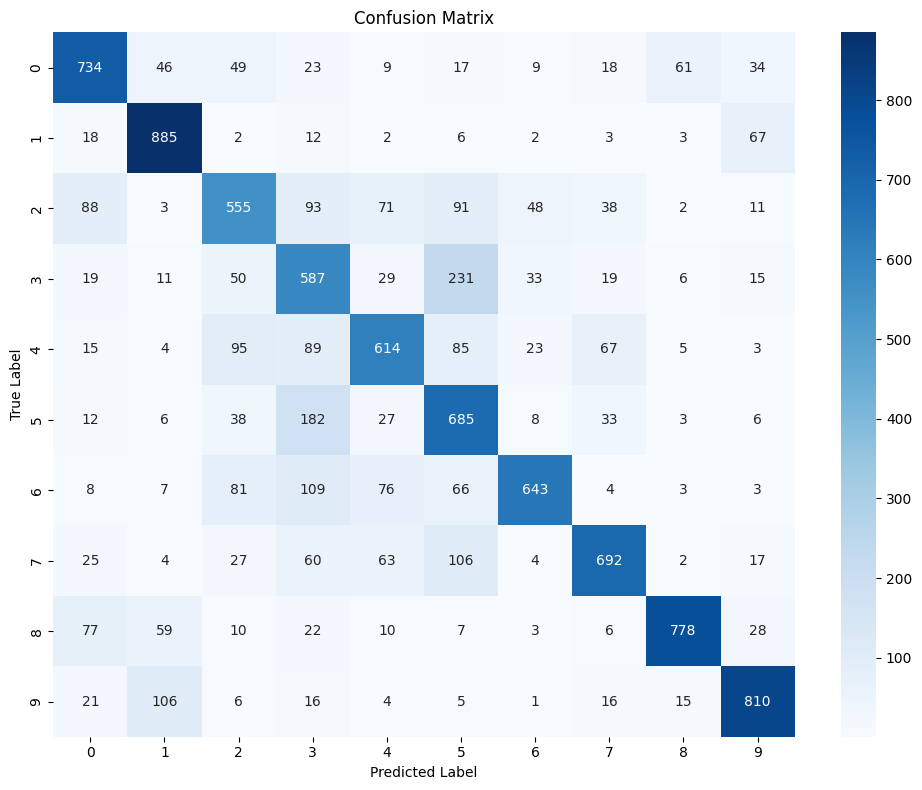

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Ensure tight layout
plt.tight_layout()

# Display the plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   The true and predicted labels for 10,000 validation samples were successfully obtained.
*   A 10x10 confusion matrix was computed using the true and predicted labels, indicating a classification problem with 10 classes.
*   A heatmap visualization of the confusion matrix was successfully generated, displaying the counts of true positives, true negatives, false positives, and false negatives for each class.

### Insights or Next Steps

*   Analyze the confusion matrix heatmap to identify which classes the model is performing well on and which classes are causing the most misclassifications.
*   Investigate specific misclassified samples to understand the reasons for errors and potentially improve the model or data.
